In [23]:
import os
import torch
import random
import copy
import csv
from PIL import Image
from torch.utils.data import DataLoader
import pandas as pd

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
import numpy as np
import pydicom as dicom
import cv2
from skimage import transform, io, img_as_float, exposure
import matplotlib.pyplot as plt

/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


DataFrame Columns: Index(['Image Filename', 'label0', 'label1', 'label2', 'label3', 'label4',
       'label5', 'label6', 'label7', 'label8', 'label9', 'label10', 'label11',
       'label12', 'label13', 'Full Image Path'],
      dtype='object')
Example Data:
      Image Filename  label0  label1  label2  label3  label4  label5  label6  \
0  00000001_000.png       0       1       0       0       0       0       0   
1  00000001_001.png       0       1       0       0       0       0       0   
2  00000001_002.png       0       1       1       0       0       0       0   
3  00000002_000.png       0       0       0       0       0       0       0   
4  00000004_000.png       0       0       0       0       1       1       0   

   label7  label8  label9  label10  label11  label12  label13  \
0       0       0       0        0        0        0        0   
1       0       0       0        1        0        0        0   
2       0       0       0        0        0        0        0   
3     

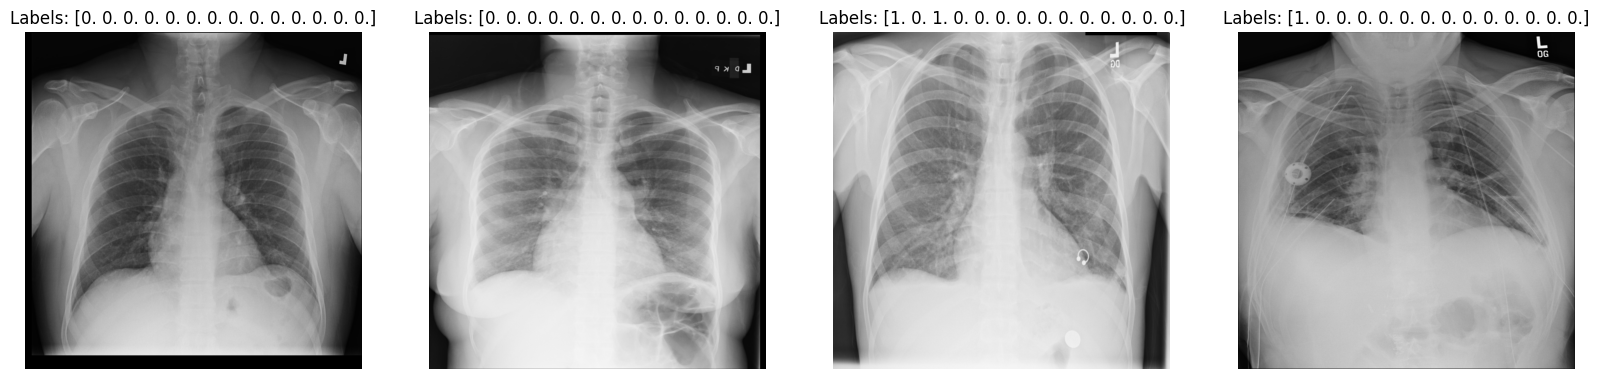

In [29]:
class ChestXray14Dataset(Dataset):
    def __init__(self, data_path, file_path, augment, num_class=14):
        self.augment = augment
        columns = ['Image Filename'] + [f'label{i}' for i in range(num_class)]
        
        # Read the data file into a DataFrame
        df = pd.read_csv(file_path, sep='\s+', names=columns)
        
        print(f"Initial DataFrame: \n{df.head()}")  # Debug print
        
        # Mapping image filenames to full paths
        subfolders = [f"images_{i:03}/images" for i in range(1, 13)]
        path_mapping = {}
        for subfolder in subfolders:
            full_folder_path = os.path.join(data_path, subfolder)
            for img_file in os.listdir(full_folder_path):
                path_mapping[img_file] = os.path.join(full_folder_path, img_file)

        # Update the DataFrame using the mapping
        df['Full Image Path'] = df['Image Filename'].map(path_mapping)
        
        # Ensure all labels are numeric and there are no missing values
        self.img_list = df['Full Image Path'].tolist()
        # Convert labels to float32 and handle only the label columns
        self.img_label = df.iloc[:, 2:num_class+2].astype(np.float32).values  # Adjust slicing based on label columns count

    def __getitem__(self, index):
        imagePath = self.img_list[index]
        imageData = Image.open(imagePath).convert('RGB')
        imageLabel = torch.from_numpy(self.img_label[index])  # Convert directly from numpy
        
        if self.augment:
            imageData = self.augment(imageData)

        return {"pixel_values": ToTensor()(imageData), "labels": imageLabel}

    def __len__(self):
        return len(self.img_list)


# Example usage
data_path = "/cluster/home/taheeraa/datasets/chestxray-14"
file_path_train = os.path.join(data_path, 'train_official.txt')
dataset_train = ChestXray14Dataset(data_path=data_path, file_path=file_path_train,
                                   augment=None, num_class=14)  # Modify augment as needed

data_loader_train = DataLoader(dataset=dataset_train, batch_size=4, shuffle=True, num_workers=4)

# Optionally, visualize the first few samples
def show_images(data_loader):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i, batch in enumerate(data_loader):
        images = batch['pixel_values']
        labels = batch['labels']
        for idx, (img, lbl) in enumerate(zip(images, labels)):
            axs[idx].imshow(img.permute(1, 2, 0))  # Change (C, H, W) to (H, W, C) for display
            axs[idx].title.set_text(f"Labels: {lbl.numpy()}")
            axs[idx].axis('off')
        break  # Only display the first batch
    plt.show()

show_images(data_loader_train)
